<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 4:
### In A Heartbeat: Prediction of Heart Disease Risk for Early Detection

---

## 3. Modeling

### 3.1 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
import time # we'll use this to see how long the models run

# For graphs and visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Essential library imports for Modeling Pre-Processing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Library to load the Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For Modeling Pipeline & Hyperparameter Tuning (GridSearchCV)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# For Modeling Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, f1_score, RocCurveDisplay

# For Deep Learning Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set theme of visualizations to ggplot
plt.style.use('ggplot')

# setting displays
%matplotlib inline
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 3.2 Import cleaned dataset

In [ ]:
df = pd.read_csv('../data/modeling_dataset.csv')
print(df.head()) # check first 5 rows

    age  height  weight     bmi  yrssmok  packday  sleep_hours chd_mi health_status phys_health_not_good mental_health_not_good last_routine_checkup visit_dentist_past_year health_insurance phy_exercise_past_30_days stroke cancer kidney_disease colon_sigmoidoscopy asthma_status race_ethnicity     sex                     education               smoker_status e_cig_smoker binge_drinker heavy_drinker income_groups
0  80.0   1.614  72.664  26.888      0.0      0.0          8.0     No     Very Good               0 days                 0 days     Within past year                     Yes              Yes                        No     No     No             No                 Yes         Never          White  Female      Grad College or Tech Sch                Never smoked           No            No            No      50K-100K
1  80.0   1.600  68.040  26.580      0.0      0.0          6.0     No     Excellent               0 days                 0 days                Never                     Y

### 3.3 Checking the dataset

#### 3.3.1 Checking columns and datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440082 entries, 0 to 440081
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        440082 non-null  float64
 1   height                     440082 non-null  float64
 2   weight                     440082 non-null  float64
 3   bmi                        440082 non-null  float64
 4   yrssmok                    440082 non-null  float64
 5   packday                    440082 non-null  float64
 6   sleep_hours                440082 non-null  float64
 7   chd_mi                     440082 non-null  object 
 8   health_status              440082 non-null  object 
 9   phys_health_not_good       440082 non-null  object 
 10  mental_health_not_good     440082 non-null  object 
 11  last_routine_checkup       440082 non-null  object 
 12  visit_dentist_past_year    440082 non-null  object 
 13  health_insurance           44

#### 3.3.2 Check for imbalanced dataset (using target variable - `chd_mi`)

In [ ]:
percentage_responses = df['chd_mi'].value_counts(normalize=True)*100

print(percentage_responses)

chd_mi
No     90.968729
Yes     9.031271
Name: proportion, dtype: float64


**Analysis:**

* We checked that there are no null values - all null values have been rectified at the data cleaning stage.
* There is a imbalance in the dataset - with 90.96% of respondents did not report having any heart disease or myocardial infarctions, while the remaining 9.03% reported having heart disease or myocardial infarctions. We will rectify the imbalance during the when fitting the model into the pipeline through parameter tuning and pipeline measures.

#### 3.3.3 Split 'X' and 'y' variables to predictor and target variables

In [ ]:
# split to predictor and target variables

y = df['chd_mi'].map({'Yes':1, 'No':0}).astype(int) # map 'Yes': 1, 'No':0 as integer
X = df.drop(columns = 'chd_mi')

### 3.4 Modeling

#### 3.4.1 Baseline Models

Prior to modeling, the null values have been rectified in the Data Cleaning stage. For the purpose of this project, we will look into 4 Classifier-type models as a baseline.

- **Logistic Regression**
  - Simplicity and Interpretability: As a straightforward algorithm, it serves as a good starting point for binary classification tasks. It provides a probabilistic framework which means that besides making predictions, it can also quantify the uncertainty of its predictions, which is useful for understanding the impact of each feature on the prediction.
  - Performance: Despite its simplicity, Logistic Regression can perform quite well on linearly separable data.
  - Speed: It's computationally inexpensive, making it fast for both training and prediction, which is beneficial when working with very large datasets.
  - Baseline Comparison: Commonly used as a benchmark because of the ease to implement and interpret.

- **XGBoost**
  - Accuracy: XGBoost is known for its high performance and speed in classification problems, using a gradient boosting framework.
  - Flexibility: XGBoost allows users to define custom optimization objectives and evaluation criteria, adding a layer of sophistication to the modeling.

- **Random Forest**
  - Versatility: Random Forest performs well on a wide range of data types without the need for extensive data preprocessing like scaling and normalization.
  - Robustness: As an ensemble method, it is less prone to overfitting than a single decision tree and often has a very good performance right out of the box.
  - Feature Importance: It provides a straightforward indication of feature importance based on how much they contribute to reducing variance, which is helpful for feature selection.

- **Decision Trees**
  
  - Non-Parametric: As a non-parametric method, it makes no assumptions about the underlying distributions of the data, which is useful for practical applications.
  - Handling Non-Linear Relationships: It can capture non-linear relationships between features and the target variable.



##### 3.4.1.1 Logistic Regression

In [ ]:
# Separate features and target from the cleaned dataframe
log_X = X.copy()
log_y = y.copy()

# Encoding categorical variables
log_X_encoded = pd.get_dummies(log_X)


# Perform the train-test split
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(log_X_encoded, log_y, test_size=0.2, stratify=log_y, random_state=42)

In [ ]:
# Feature scaling of numerical variables
scaler = StandardScaler()
log_X_train_scaled = scaler.fit_transform(log_X_train)
log_X_test_scaled = scaler.transform(log_X_test)

In [ ]:
%%time

# Initialize the Logistic Regression model with a higher max_iter
model = LogisticRegression(max_iter=5000, random_state=42)

# Train the model on the scaled data
model.fit(log_X_train_scaled, log_y_train)

# Make predictions using the scaled data
log_train_pred = model.predict(log_X_train_scaled)
log_test_pred = model.predict(log_X_test_scaled)

# Calculate and print training and test accuracies
log_train_accuracy = accuracy_score(log_y_train, log_train_pred)
log_test_accuracy = accuracy_score(log_y_test, log_test_pred)
print(f"LogReg Train Accuracy: {log_train_accuracy:.2f}")
print(f"LogReg Test Accuracy: {log_test_accuracy:.2f}")

# Scale the data for cross-validation
log_cv_scores = cross_val_score(model, scaler.fit_transform(log_X_encoded), log_y, cv=5, scoring='accuracy')

# Print the average of the cross-validation scores and scores for each fold
print(f"LogReg Cross-Validation: {log_cv_scores.mean():.2f}")
print(f"LogReg Cross-Validation (per Fold): {[f'{score:.2f}' for score in log_cv_scores]}")

LogReg Train Accuracy: 0.91
LogReg Test Accuracy: 0.91
LogReg Cross-Validation: 0.91
LogReg Cross-Validation (per Fold): ['0.91', '0.91', '0.91', '0.91', '0.91']
CPU times: user 35.2 s, sys: 920 ms, total: 36.1 s
Wall time: 6.08 s


##### 3.4.1.2 XGBoost

In [ ]:
# Assign features and target
xg_X = X.copy()
xg_y = y.copy()

# categorical variables
cat_col = ['health_status', 'phys_health_not_good', 'mental_health_not_good',
       'last_routine_checkup', 'visit_dentist_past_year', 'health_insurance',
       'phy_exercise_past_30_days', 'stroke', 'cancer', 'kidney_disease',
       'colon_sigmoidoscopy', 'asthma_status', 'race_ethnicity', 'sex',
       'education', 'smoker_status', 'e_cig_smoker', 'binge_drinker',
       'heavy_drinker', 'income_groups']

# One-hot encode the categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
xg_X_categorical_encoded = encoder.fit_transform(xg_X[cat_col])

# Perform the train-test split
xg_X_train, xg_X_test, xg_y_train, xg_y_test = train_test_split(xg_X_categorical_encoded, xg_y, test_size=0.2, stratify=xg_y, random_state=42)

In [ ]:
%%time
# Initialize the XGBoost classifier with enable_categorical=True
model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', enable_categorical=True)

# Train the model
model.fit(xg_X_train, xg_y_train)

# Make predictions on training and test sets
xg_train_pred = model.predict(xg_X_train)
xg_test_pred = model.predict(xg_X_test)

# Calculate and print training and test accuracies
xg_train_accuracy = accuracy_score(xg_y_train, xg_train_pred)
xg_test_accuracy = accuracy_score(xg_y_test, xg_test_pred)
print(f"XGBoost Train Accuracy: {xg_train_accuracy:.2f}")
print(f"XGBoost Test Accuracy: {xg_test_accuracy:.2f}")

# Ensure X is suitable for cross-validation by converting object types to 'category'
xg_X_for_cv = xg_X.copy()
for col in xg_X_for_cv.columns:
    if xg_X_for_cv[col].dtype == 'object':
        xg_X_for_cv[col] = xg_X_for_cv[col].astype('category')

# Perform 5-fold cross-validation
xg_cv_scores = cross_val_score(model, xg_X_for_cv, xg_y, cv=5, scoring='accuracy')

# Print the average of the cross-validation scores and the scores for each fold
print(f"XGBoost Cross-Validation: {xg_cv_scores.mean():.2f}%")
print(f"XGBoost Cross-Validation (per Fold): {[f'{score:.2f}' for score in xg_cv_scores]}")

XGBoost Train Accuracy: 0.91
XGBoost Test Accuracy: 0.91
XGBoost Cross-Validation: 0.91%
XGBoost Cross-Validation (per Fold): ['0.91', '0.91', '0.91', '0.91', '0.91']
CPU times: user 39.6 s, sys: 10.1 s, total: 49.7 s
Wall time: 8.21 s


##### 3.4.1.3 Random Forest

In [ ]:
# Assign features and target
rf_X = X.copy()
rf_y = y.copy()

# Encoding categorical variables
rf_X_encoded = pd.get_dummies(rf_X)

# Splitting dataset into training and testing sets
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X_encoded, rf_y, test_size=0.2, stratify=rf_y, random_state=42)

In [ ]:
%%time

# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)

# Training the model
model.fit(rf_X_train, rf_y_train)

# Making predictions for evaluation
rf_y_train_pred = model.predict(rf_X_train)
rf_y_test_pred = model.predict(rf_X_test)

# Calculating Train and Test accuracy scores
rf_train_accuracy = accuracy_score(rf_y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(rf_y_test, rf_y_test_pred)
print(f"Random Forest Train Accuracy: {rf_train_accuracy:.2f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.2f}")

# Perform 5-fold cross-validation to evaluate the model
rf_cv_scores = cross_val_score(model, rf_X_encoded, rf_y, cv=5)

# Calculate and print the average of the cross-validation scores
cv_mean = rf_cv_scores.mean()
cv_std = rf_cv_scores.std()
print(f"Random Forest Cross-Validation: {rf_cv_scores.mean():.2f}")
print(f"Random Forest Cross-Validation (per Fold): {[f'{score:.2f}' for score in rf_cv_scores]}")

Random Forest Train Accuracy: 1.00
Random Forest Test Accuracy: 0.91
Random Forest Cross-Validation: 0.91
Random Forest Cross-Validation (per Fold): ['0.91', '0.91', '0.91', '0.91', '0.91']
CPU times: user 3min 32s, sys: 1.02 s, total: 3min 33s
Wall time: 3min 37s


##### 3.4.1.4 Decision Tree

In [ ]:
# Assign features and target
dt_X = X.copy()
dt_y = y.copy()

# Separate numerical and categorical columns
numeric_features = dt_X[['age', 'height', 'weight', 'bmi', 'yrssmok', 'packday', 'sleep_hours']] # numerical variables
categorical_features = dt_X[['health_status', 'phys_health_not_good', 'mental_health_not_good', # categorical variables
       'last_routine_checkup', 'visit_dentist_past_year', 'health_insurance',
       'phy_exercise_past_30_days', 'stroke', 'cancer', 'kidney_disease',
       'colon_sigmoidoscopy', 'asthma_status', 'race_ethnicity', 'sex',
       'education', 'smoker_status', 'e_cig_smoker', 'binge_drinker',
       'heavy_drinker', 'income_groups']]

# Scale the numerical features
scaler = StandardScaler()
dt_X_numeric_scaled = scaler.fit_transform(numeric_features)

# One-hot encode the categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
dt_X_categorical_encoded = encoder.fit_transform(categorical_features)

# Combine the processed numerical and categorical features back into a single dataset
dt_X_processed = np.concatenate([dt_X_numeric_scaled, dt_X_categorical_encoded.toarray()], axis=1)

# split it into training and testing sets
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X_processed, dt_y, test_size=0.2, stratify=dt_y, random_state=42)

In [ ]:
%%time

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(dt_X_train, dt_y_train)

# Make predictions
dt_y_train_pred = model.predict(dt_X_train)
dt_y_test_pred = model.predict(dt_X_test)

# Evaluate the model
dt_train_accuracy = accuracy_score(dt_y_train, dt_y_train_pred)
dt_test_accuracy = accuracy_score(dt_y_test, dt_y_test_pred)
print(f"Decision Trees Train Accuracy: {dt_train_accuracy:.2f}")
print(f"Decision Trees Test Accuracy: {dt_test_accuracy:.2f}")

# Preprocessing for CV score
for col in dt_X.columns:
    if dt_X[col].dtype == 'object':
        dt_X[col] = dt_X[col].astype('category')

# get the cross validation scores
dt_cv_scores = cross_val_score(model, dt_X_processed, dt_y, cv=5)
cv_mean = dt_cv_scores.mean()
cv_std = dt_cv_scores.std()
print(f"Decision Trees Cross-Validation: {dt_cv_scores.mean():.2f}")
print(f"Decision Trees Cross-Validation (per Fold): {[f'{score:.2f}' for score in dt_cv_scores]}")

Decision Trees Train Accuracy: 1.00
Decision Trees Test Accuracy: 0.86
Decision Trees Cross-Validation: 0.85
Decision Trees Cross-Validation (per Fold): ['0.85', '0.85', '0.85', '0.86', '0.86']
CPU times: user 20.2 s, sys: 222 ms, total: 20.5 s
Wall time: 20.8 s


**Analysis:**

Albeit, the relatively high scores generally, the Logistic Regression and XGBoost models stood out in terms of:

* Consistent Performance: The model has demonstrated consistently high accuracy across training, testing, and cross-validation, suggesting the well-generalized model that is not overfitting the data.

* Simplicity and Interpretability: Logistic Regression’s simplicity is a considerable advantage. It’s faster to train and easier to interpret than more complex models. This is  beneficial when explaining the model's predictions and decisions to non-technical stakeholders.

* Baseline Performance: Given that Logistic Regression is often used as a baseline model, its strong performance here validates its effectiveness for this particular dataset and problem. No doubt, XGBoost has a marginally higher training accuracy compared to Logistic Regression and holds its ground on test accuracy, suggesting it can capture complex patterns in the data without overfitting.

* Robustness to Variance: Given the slightly better performance on the training set with no loss on the test set, XGBoost may be more robust to variance in the data than Logistic Regression.


To further the point, the reason why Random Forest and Decision Trees were not chosen are as follows:

* Overfitting
  * The Random Forest training accuracy compared to its test accuracy indicates that it has overfit the training data.
  * The decision tree model shows an almost perfect training score but significantly lower test accuracy, which is a clear indicator of overfitting.

* Computational Limitations: Random Forest can be more computationally expensive and time-consuming (8mins), which could be a concern for larger datasets or limited computational resources, especially when we include tuned parameters.

* Poor Generalization:
  * The drop in cross-validation mean score in the Decision Trees model further supports the poor generalization capability of the decision tree model to unseen data compared to the other models.
  * Although there is high test accuracy in Random Forest, the discrepancy suggests that the model may not generalize as well to unseen data.

#### 3.4.2 Modeling with Parameters

For the hyperparameter tuning, we will narrow in on Logistic Regression as part of our model comparison.

##### 3.4.2.1 Initializing the Pipeline

Initialize the pipelines for the LogReg and XGBoost model with the following items:

* `Scaler`: We use `StandardScaler` here. Removes the mean and scales the graph to unit variance. This ensures consistency and efficiency of the train data when modeled.
* `SMOTE`: Synthetically Oversamples the Minority Class to balance the class distributed, using a small k-nearest neighbouring technique. Most suitable for imbalanced dataset such as the one we're using here. We initially considered the use of `ADASYN` to handle imbalance, however the time required to process was >4x times that required of the `SMOTE` technique. Moreoever, the results from the 2 techniques very marginally affects the Train-Test score of the hypertuned models (0.001). In this case, we also used `sampling_strategy` here will enable the minority class to be oversampled to have 20% the number of majority class samples.
* `Model`: Including the model as the last step in the pipeline allows for seamless integration of preprocessing steps and model training, facilitating a straightforward and reproducible process for model evaluation and selection.
  * Logistic Regression: The simplicity of the binary (0 or 1), and Probability (0 to 1) output often leads to ease of reader's interpretability.
  * XGBoost: Average target value for regression tasks or the log odds for a classification. The use of XGBoost will also help to regulate overfitting at an efficient and speedy manner.

In [ ]:
# Logistic Regression Pipeline
imb_logistic_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
    ('model', LogisticRegression(random_state=42))
])

##### 3.4.2.2 Parameter Grids

The following parameters have been meticulously selected to fine-tune the models for optimal performance, especially when dealing with imbalanced and also huge dataset such as ours (400+K).

**1) Logistic Regression**
* `C`: Tests a range from strong to weak regularization to balance model complexity and accuracy.
* `penalty`: 'l2' helps manage multicollinearity and model generalization.
* `solver`: 'saga' is chosen for its efficiency with large data and support for 'l1' and 'l2' penalties.
* `class_weight`: 'None' means that there are no class weights assigned, while 'balanced' adjusts weights inversely to class frequencies, addressing class imbalance.
* `max_iter`: Higher iterations taken for the solver to converge, higher is required for large complex datasets.

In [ ]:
# Use StratifiedKFold for handling imbalanced datasets
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid - Logistic Regression
logistic_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [500, 1000],
    'smote__sampling_strategy': [0.1, 0.2, 0.3],  # Trying different oversampling ratios
}

##### 3.4.2.3 Hypertune the Selected Model with GridSearchCV (LogReg)

**Metrics for consideration:**
Beyond just the CV and Train-test score in evaluating the hypertuned models, we should look into F1 score and ROC AUC score as well, since there is a class imbalance in our dataset.

* Sensivity
  - Early Detection: High sensitivity is essential for early detection of CHD/MI, as it ensures that most patients who have the disease are identified early, which can be crucial for timely treatment and better outcomes.

  - Reducing False Negatives: Sensitivity is a measure of how well the model minimizes false negatives. In the case of CHD/MI, a false negative (failing to identify someone with the disease) can be life-threatening, making it important to have a test that captures as many true cases as possible.

  - Public Health Strategy: When implementing a screening tool in a telehealth application, public health strategies prioritize identifying individuals who might be at risk. A high sensitivity ensures that fewer cases are missed, which is more acceptable than having false positives in initial screening stages.

  - Patient Assurance: Patients who are concerned about their heart health can be more assured if the test has a high sensitivity, as they can trust that a negative result is truly negative.

  - Healthcare Workflow: High sensitivity in preliminary screenings can help healthcare providers prioritize and manage follow-up procedures, such as confirmatory tests or more intensive diagnostics, for those who test positive.

  - Cost-Effectiveness: Although tests with high sensitivity may result in more false positives, they can still be more cost-effective than missing a diagnosis. The cost of treating late-stage CHD/MI can be significantly higher than the cost of additional testing resulting from initial false positives.

* ROC AUC Score:
  - Performance at Various Thresholds: The ROC curve illustrates the model's performance across all classification thresholds, not just the default. This is crucial for medical diagnostics, where the threshold for predicting a positive case can be adjusted based on clinical requirements.
  
  - Discrimination Ability: AUC measures the model's ability to discriminate between positive (having the disease) and negative cases (not having the disease), regardless of the prevalence. This is especially relevant in disease screening where it's critical to distinguish between healthy and affected individuals.
  
  - Balance of Sensitivity and Specificity: The AUC score gives a single measure of how well the model balances sensitivity (true positive rate) and specificity (true negative rate). For CHD/MI, you want to correctly identify as many true cases as possible (sensitivity) while also correctly identifying those without the disease (specificity).
  
  - Model Comparison: The AUC score is often used to compare different models or approaches. In your study, it could be used to determine which model performs better overall in distinguishing between patients with and without CHD/MI.
  
  - Aggregated Performance: The AUC score is not affected by the change in the proportion of positive and negative classes, making it a good metric for evaluating model performance when there is an imbalance in the dataset.
  
  - Clinical Decision Making: The ROC AUC score can inform clinicians about the probability of a patient having the disease, which can be a vital aid in deciding further clinical action, treatment plans, or the need for more diagnostic tests.

##### 3.4.2.4 Running the (hypertuned) Logistic Regression Model

In [ ]:
# Assign features and target
loghyp_X = X.copy()
loghyp_y = y.copy()

# Encoding categorical variables
loghyp_X_encoded = pd.get_dummies(loghyp_X)


# Perform the train-test split
loghyp_X_train, loghyp_X_test, loghyp_y_train, loghyp_y_test = train_test_split(loghyp_X_encoded, loghyp_y, test_size=0.2, stratify=loghyp_y, random_state=42)

In [ ]:
%%time

# Instantiate GridSearchCV (LogReg)
logistic_grid_search = GridSearchCV(imb_logistic_pipeline, logistic_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
logistic_grid_search.fit(loghyp_X_train, loghyp_y_train)

CPU times: user 18.6 s, sys: 4.14 s, total: 22.7 s
Wall time: 10min 44s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.2)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'], 'model__solver': ['saga'],
                         'smote__sampling_strategy': [0.1, 0.2, 0.3]},
             scoring='roc_auc')

In [ ]:
# Best parameters and CV score
print("Best parameters for (hypertuned)Logistic Regression:", logistic_grid_search.best_params_)
print(f"Best CV score for (hypertuned) Logistic Regression: {logistic_grid_search.best_score_:.2f}")

# Evaluate on training data using the best estimator found by GridSearchCV
loghyp_y_train_pred = logistic_grid_search.predict(loghyp_X_train)
loghyp_train_accuracy = accuracy_score(loghyp_y_train, loghyp_y_train_pred)
print(f"Train accuracy for (hypertuned) Logistic Regression: {loghyp_train_accuracy:.2f}")

# Evaluate on test data using the best estimator found by GridSearchCV
loghyp_y_test_pred = logistic_grid_search.predict(loghyp_X_test)
loghyp_test_accuracy = accuracy_score(loghyp_y_test, loghyp_y_test_pred)
print(f"Test accuracy for (hypertuned) Logistic Regression: {loghyp_test_accuracy:.2f}")

#  mean CV score for the best estimator across folds
loghyp_best_index = logistic_grid_search.best_index_
loghyp_mean_cv_score = logistic_grid_search.cv_results_['mean_test_score'][loghyp_best_index]
loghyp_std_cv_score = logistic_grid_search.cv_results_['std_test_score'][loghyp_best_index]
print(f"Mean CV score for the best (hypertuned) Logistic Regression model: {loghyp_mean_cv_score:.2f} ± {loghyp_std_cv_score:.2f}")

Best parameters for (hypertuned)Logistic Regression: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'saga', 'smote__sampling_strategy': 0.1}
Best CV score for (hypertuned) Logistic Regression: 0.84
Train accuracy for (hypertuned) Logistic Regression: 0.74
Test accuracy for (hypertuned) Logistic Regression: 0.74
Mean CV score for the best (hypertuned) Logistic Regression model: 0.84 ± 0.00


In [ ]:
# Metric Evaluation - LogReg (hypertuned)
# Use the best estimator to make predictions on both the test and train set
loghyp_best_estimator = logistic_grid_search.best_estimator_

# Making predictions on both the test and train data
loghyp_y_train_pred = loghyp_best_estimator.predict(loghyp_X_train)
loghyp_y_test_pred = loghyp_best_estimator.predict(loghyp_X_test)


# Get probabilities for the positive class for both the test and train data
loghyp_y_train_proba = loghyp_best_estimator.predict_proba(loghyp_X_train)[:, 1]
loghyp_y_test_proba = loghyp_best_estimator.predict_proba(loghyp_X_test)[:, 1]

# Evaluation metrics for both sets
for set_name, y_true, y_pred, y_proba in [
    ('Train', loghyp_y_train, loghyp_y_train_pred, loghyp_y_train_proba),
    ('Test', loghyp_y_test, loghyp_y_test_pred, loghyp_y_test_proba)
]:
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred, average='binary')

    # Extracting TP, TN, FP, FN from the confusion matrix
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    # Calculating Sensitivity, Specificity, Precision, and NPV
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    npv = TN / (TN + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Print metrics
    print(f"{set_name} Set")
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"NPV: {npv:.4f}\n")
    print(f"Accuracy: {accuracy:.4f}\n")

Train Set
Confusion Matrix:
 [[236819  83450]
 [  6903  24893]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84    320269
           1       0.23      0.78      0.36     31796

    accuracy                           0.74    352065
   macro avg       0.60      0.76      0.60    352065
weighted avg       0.90      0.74      0.80    352065

ROC AUC Score: 0.8379
F1 Score: 0.3553
Sensitivity: 0.7829
Specificity: 0.7394
Precision: 0.2298
NPV: 0.9717

Accuracy: 0.7434

Test Set
Confusion Matrix:
 [[59175 20893]
 [ 1690  6259]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84     80068
           1       0.23      0.79      0.36      7949

    accuracy                           0.74     88017
   macro avg       0.60      0.76      0.60     88017
weighted avg       0.91      0.74      0.80     88017

ROC AUC Score: 0.8395
F1 Score: 0.3566
Sensit

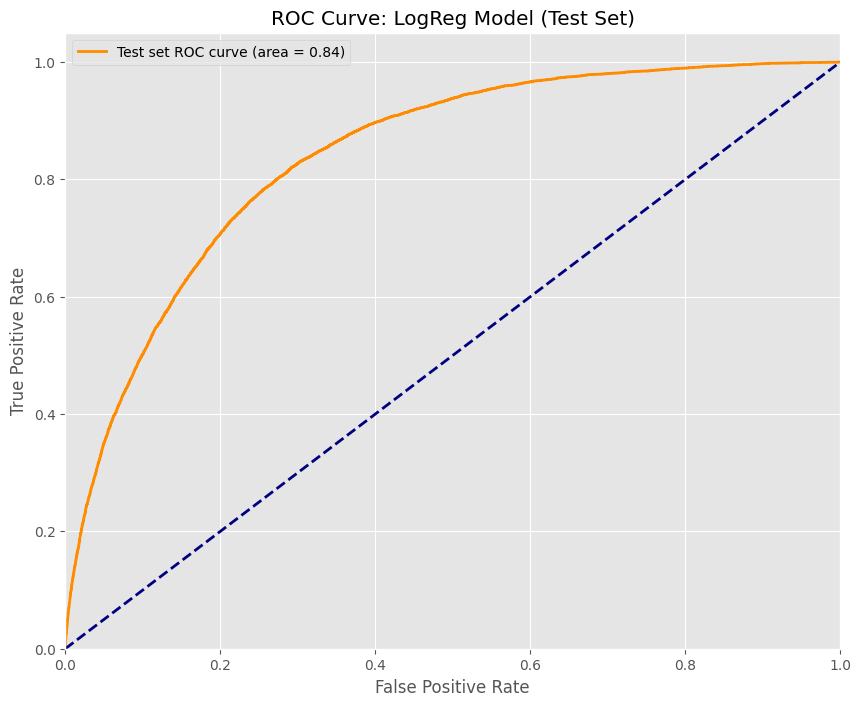

In [ ]:
# ROC Curve - LogReg (hypertuned)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{set_name} set ROC curve (area = {roc_auc_value:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: LogReg Model ({set_name} Set)')
plt.legend(loc="upper left")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

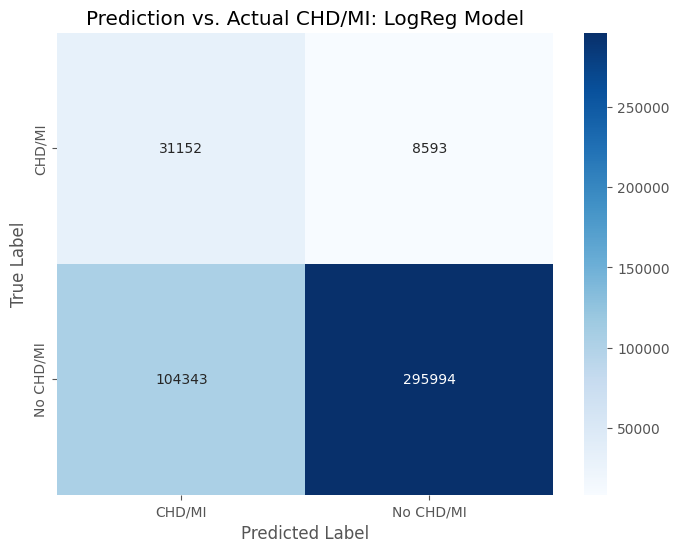

In [ ]:
# Confusion Matrix Heatmap - LogReg (hypertuned)

# Use the best estimator to make predictions on both the train and test sets
loghyp_y_train_pred = loghyp_best_estimator.predict(loghyp_X_train)
loghyp_y_test_pred = loghyp_best_estimator.predict(loghyp_X_test)

# Generate confusion matrices for both the train and test sets
loghyp_train_conf_matrix = confusion_matrix(loghyp_y_train, loghyp_y_train_pred)
loghyp_test_conf_matrix = confusion_matrix(loghyp_y_test, loghyp_y_test_pred)

# Combine the confusion matrices by adding them together
log_conf_matrix = loghyp_train_conf_matrix + loghyp_test_conf_matrix


# Reorder the confusion matrix to the desired format [[TP, FP], [FN, TN]]
log_conf_matrix_reorder = np.flip(log_conf_matrix)

# Plot the reordered confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(log_conf_matrix_reorder, annot=True, fmt='d', cmap='Blues',
            xticklabels=['CHD/MI', 'No CHD/MI'],
            yticklabels=['CHD/MI', 'No CHD/MI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Prediction vs. Actual CHD/MI: LogReg Model')
plt.show()

**Analysis:**

* True Positives (TP): 31,152 - This is the count of cases where the model correctly predicted the presence of CHD/MI. The percentage indicates that approximately 7.09% of the total cases were correctly identified as positive.

* False Negatives (FN): 8,593 - These are the cases that the model incorrectly predicted as negative (no CHD/MI) when they actually were positive cases. The low percentage (1.95%) suggests that the model is relatively good at detecting the positive cases.

* False Positives (FP): 104,343 - Here, the model incorrectly predicted CHD/MI in patients who did not have the condition. The higher percentage (23.71%) indicates that there's a significant number of individuals who might be incorrectly diagnosed as at risk.

* True Negatives (TN): 295,994 - These are cases where the model correctly identified no presence of CHD/MI.The high percentage (67.25%) suggests that the model is quite effective at identifying true negative cases.


**Insights:**

* The model has a high TN rate, indicating strong specificity – it's good at identifying those without the disease.

* However, the high FP rate could lead to a large number of individuals being unnecessarily worried or subjected to further testing, increasing healthcare costs and potentially leading to psychological distress.

* The low FN rate is positive, indicating that it misses very few actual cases of CHD/MI.

* The TP rate, while not very high, indicates that the model has reasonable sensitivity – it can identify a fair number of true positive cases.


**Implications on Metrics:**

* Precision: Given the high number of FPs, the precision of the model (the proportion of positive identifications that were actually correct) would be relatively low.

* Recall (Sensitivity): The recall would be relatively high, as the model has a lower FN rate; it's able to identify most of the positive cases.

* Accuracy: The overall accuracy (the proportion of all predictions that are correct) might seem high due to the substantial number of TNs, but this doesn't tell the full story as the FP rate is also high.

* F1 Score: This harmonic mean of precision and recall might be lower due to the lower precision, even if the recall is high.

* ROC AUC Score: This score would probably be affected by the high FP rate, as the ROC curve takes into account both the true positive rate and the false positive rate, hence it is high.


**Overall Model Performance:**

* For a teledoctor service using this model as a preliminary heart disease risk tool, these interpretations suggest that while the model is good at ruling out disease, it may cause undue concern due to the high number of false positives. The service should ensure appropriate follow-up and stress the preliminary nature of the assessment to avoid panic and unnecessary interventions.




---
#### 3.4.3 Deep Learning Modeling (Keras)

Beyond the traditional types of modeling, we will also explore a type of Feedforward Neural Network (FNN) known as Keras, specifically designed for binary classification tasks, to compare with our hypertuned "traditional" models. This type of network is also commonly referred to as a Multilayer Perceptron (MLP) when it includes one or more hidden layers, as is the case here.

In the case here, where we're determining the predictability of a binary classification task,(having heart disease/myocardial infarction or not), we will adopt `binary crossentropy` as the loss function. This loss function is designed for two-class classification problems.

As for the activation function, the `sigmoid` is appropriate for binary classification tasks when using neural networks. It will output a value between 0 and 1, which is typically interpreted as the probability of belonging to the positive class.

* Performance Metrics: Train-Test Accuracy Score is will be used to compare against the traditional models, to evaluate the model's performance, indicating how often the model correctly classifies the input data.

##### 3.4.3.1 Binary Crossentropy

In [ ]:
# set random seed
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Assign features and target
fnn_X = X.copy()
fnn_y = y.copy()

# Encoding categorical variables
fnn_X_encoded = pd.get_dummies(fnn_X)

# Perform the train-test split
fnn_X_train, fnn_X_test, fnn_y_train, fnn_y_test = train_test_split(fnn_X_encoded, fnn_y, test_size=0.2, stratify=fnn_y, random_state=42)

# Feature scaling
scaler = StandardScaler()
fnn_X_train_scaled = scaler.fit_transform(fnn_X_train)
fnn_X_test_scaled = scaler.transform(fnn_X_test)

In [ ]:
%%time

# Dimension shape
n_input = fnn_X_train.shape[1]

# Define the Keras model with potentially more complexity
model = Sequential()
model.add(Dense(128, input_dim=n_input, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Adjust the optimizer
opt = Adam(learning_rate=0.0001)

# Compile the model with a weighted binary crossentropy
weights = {0: 1, 1: 12}  # Adjust the weight for the positive class

# reset index so weights variable can take effect
fnn_y_train = fnn_y_train.reset_index(drop=True)


model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-6)
]

# Fit the model with class weights for imbalance
history = model.fit(
    fnn_X_train_scaled, fnn_y_train,
    validation_split=0.3,
    epochs=100,  # Increased epochs
    batch_size=64,  # Reduced batch size
    verbose=1,
    callbacks=callbacks,
    class_weight = weights
)

# Convert probabilities to binary predictions using 0.5 as a threshold
threshold = 0.5
fnn_y_test_proba = model.predict(fnn_X_test_scaled, verbose=0).flatten()
fnn_y_test_pred = (fnn_y_test_proba > threshold).astype(int)

# Calculate metrics
conf_matrix = confusion_matrix(fnn_y_test, fnn_y_test_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
npv = TN / (TN + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
fnn_roc_auc = roc_auc_score(fnn_y_test, fnn_y_test_proba)
fnn_f1 = f1_score(fnn_y_test, fnn_y_test_pred)

# Print the metrics
print(f'FNN Train Accuracy: {model.evaluate(fnn_X_train_scaled, fnn_y_train, verbose=0)[1]:.4f}')
print(f'FNN Test Accuracy: {model.evaluate(fnn_X_test_scaled, fnn_y_test, verbose=0)[1]:.4f}')
print(f'FNN ROC AUC Score: {fnn_roc_auc:.4f}')
print(f'FNN F1 Score: {fnn_f1:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'NPV: {npv:.4f}')
print(f'Accuracy: {accuracy:.4f}')

/opt/anaconda3/envs/GA-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 3s 590us/step - accuracy: 0.5871 - loss: 1.3235 - val_accuracy: 0.6639 - val_loss: 0.5653 - learning_rate: 1.0000e-04
Epoch 2/100
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.6568 - loss: 1.0745 - val_accuracy: 0.6600 - val_loss: 0.5491 - learning_rate: 1.0000e-04
Epoch 3/100
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 2s 554us/step - accuracy: 0.6643 - loss: 1.0415 - val_accuracy: 0.6696 - val_loss: 0.5404 - learning_rate: 1.0000e-04
Epoch 4/100
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.6727 - loss: 1.0293 - val_accuracy: 0.6747 - val_loss: 0.5392 - learning_rate: 1.0000e-04
Epoch 5/100
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 2s 576us/step - accuracy: 0.6781 - loss: 1.0182 - val_accuracy: 0.6810 - val_loss: 0.5364 - learning_rate: 1.0000e-04
Epoch 6/100
3851/3851 ━━━━━━━━━━━━━━━━━━━━ 2s 548us/step - accuracy: 0.6820 - loss: 1.0164 - val_accuracy: 0.6818 - val_loss: 0.5388 - learning_rate: 1.0000e-04
Epoch 7/100
3851/3851 ━━━━━━━━━━━━

In [ ]:
# Summary representation of the model from the different Denses
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 128)            │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,845 (202.52 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,564 (135.02 KB)

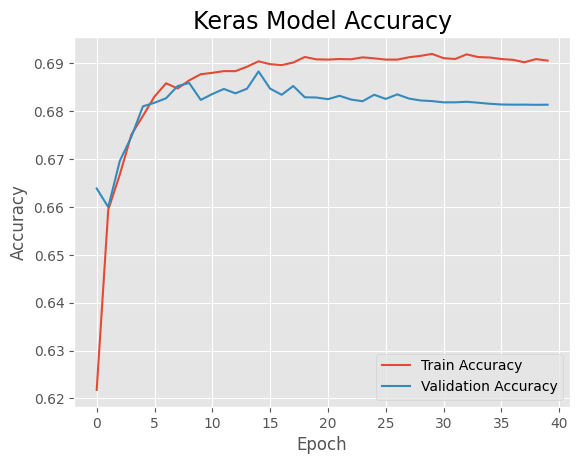

In [ ]:
# Model Accuracy Plot - Keras model

#Plot accuracy or loss over epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')

# add plot info
plt.title('Keras Model Accuracy', size=17)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')

plt.show()

**Analysis:**
* Training Accuracy: The red line represents the accuracy of the model on the training data. It shows how well the model is learning to classify the data it has seen.

* Validation Accuracy: The blue line represents the accuracy on the validation data. This is new data for the model, which simulates how well the model might perform on data it hasn't seen before.


**Interpretation:**
* The training accuracy quickly improves in the first few epochs, indicating that the model is learning from the training data.

* After the initial jump, the training accuracy plateaus around 0.68, suggesting that the model has learned as much as it can from the training data and further learning doesn't significantly improve its performance on this data.

* The validation accuracy closely follows the training accuracy, which is a good sign. It suggests that the model is not overfitting to the training data. Overfitting would be indicated by a high training accuracy but much lower validation accuracy.

* Both accuracies are fairly stable after about 5 epochs, with only minor fluctuations. This could mean that running more epochs might not lead to significant improvements.

* Overall, the model seems to perform consistently over time without overfitting. However, the accuracy seems to hover around 0.68, which might not be sufficient for some applications. It's worth considering strategies to improve the model's performance, which could include data augmentation, hyperparameter tuning, or using a different modeling architecture.


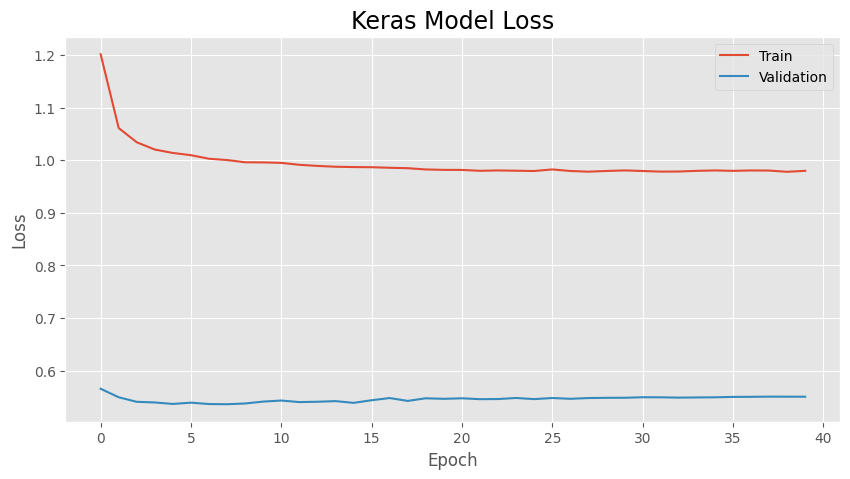

In [ ]:
# Loss Plot - Keras model

# Plot training & validation loss values

# set figure size
plt.figure(figsize=(10, 5))

# plot loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# add plot info
plt.title('Keras Model Loss', size=17)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

**Analysis:**

* Training Loss: The red line shows the loss on the training data. This metric decreases rapidly at first as the model begins learning from the data but then levels off as the model starts to converge on a solution.

* Validation Loss: The blue line shows the loss on the validation data. This represents new data for the model, showing how well the model might perform in generalizing to unseen data.

**Interpretation:**

* Both training and validation losses decrease and stabilize early in training, which is a good sign. It indicates that the model is learning and generalizing well from the training data.

* The relatively close proximity of the training and validation losses suggests that the model is not overfitting. Overall, the graph suggests a well-fitting model that is learning effectively without overfitting.

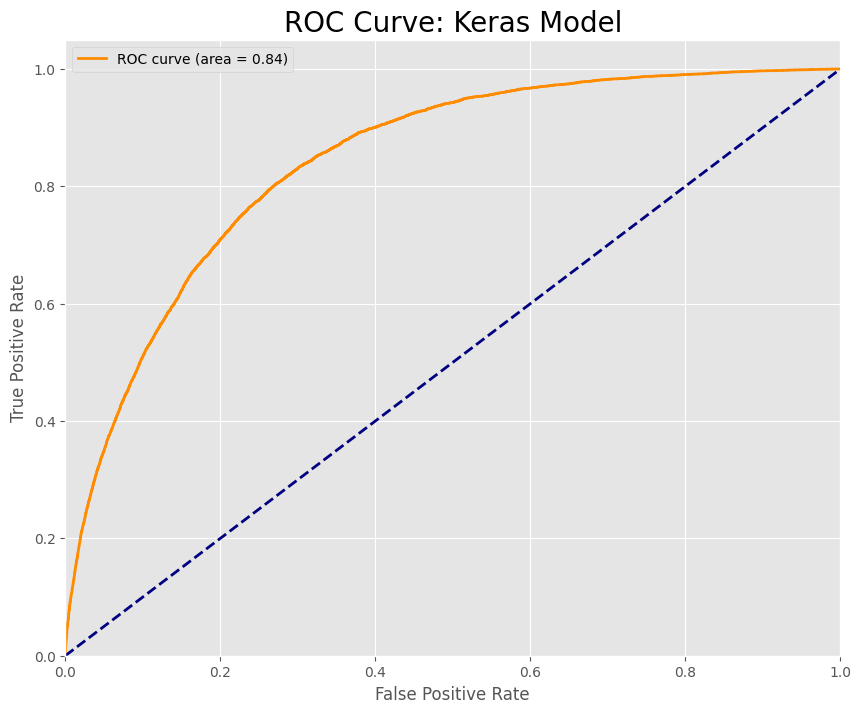

In [ ]:
# ROC Curve - Keras model
# Generate ROC curve values: false positives rate, true positives rate
fpr, tpr, thresholds = roc_curve(fnn_y_test, fnn_y_test_proba)

# Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# add plot info
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Keras Model', size=20)
plt.legend(loc="upper left")

plt.show()

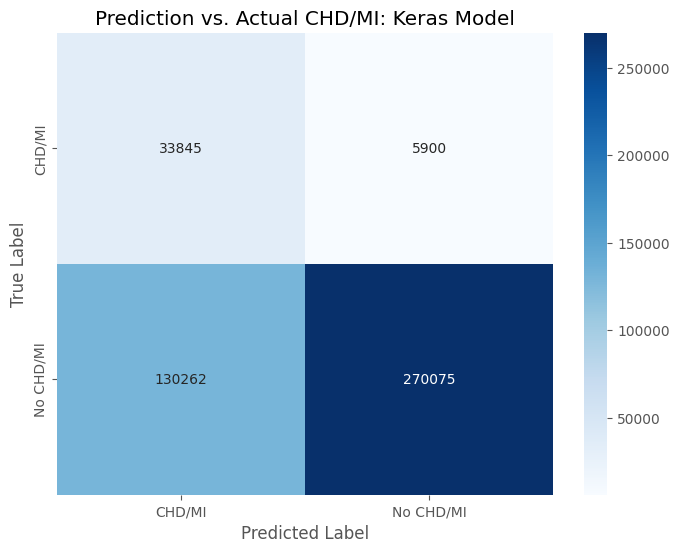

In [ ]:
# Confusion Matrix Heatmap - Keras model
# Predict probabilities for both the test and train set
fnn_y_train_proba = model.predict(fnn_X_train_scaled, verbose=0)
fnn_y_test_proba = model.predict(fnn_X_test_scaled, verbose=0)

# Convert probabilities to binary predictions using the threshold
threshold = 0.5
fnn_y_train_pred = np.where(fnn_y_train_proba.flatten() > threshold, 1, 0)
fnn_y_test_pred = np.where(fnn_y_test_proba.flatten() > threshold, 1, 0)

# Compute confusion matrices
fnn_train_conf_matrix = confusion_matrix(fnn_y_train, fnn_y_train_pred)
fnn_test_conf_matrix = confusion_matrix(fnn_y_test, fnn_y_test_pred)

# Combine the confusion matrices
fnn_combined_conf_matrix = fnn_train_conf_matrix + fnn_test_conf_matrix

# Reorder the confusion matrix to the desired format [[TP, FP], [FN, TN]]
fnn_conf_matrix_reorder = np.flip(fnn_combined_conf_matrix)


# Plot the reordered confusion matrix
plt.figure(figsize=(8, 6))

# plot heatmap
sns.heatmap(fnn_conf_matrix_reorder, annot=True, fmt='d', cmap='Blues',
            xticklabels=['CHD/MI', 'No CHD/MI'],
            yticklabels=['CHD/MI', 'No CHD/MI'])

# add plot info
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Prediction vs. Actual CHD/MI: Keras Model')

plt.show()



**Analysis:**

* True Positives (TP): 33,845 individuals were correctly identified as having CHD/MI. This is a crucial figure as it represents the model's ability to correctly identify those who are actually at risk of heart disease, which is essential for a diagnostic tool.

* False Negatives (FN): 5,900 individuals were incorrectly identified as not having CHD/MI. These represent the most dangerous type of error, where the model fails to identify the disease, possibly delaying treatment for affected individuals.

* False Positives (FP): 130,262 individuals were incorrectly identified as having CHD/MI. These are the cases where the model predicted the positive class (disease present) when it was not, which can lead to unnecessary stress and further testing for those individuals.

* True Negatives (TN): 270,075 individuals were correctly identified as not having CHD/MI. This is the number of correct predictions where the model has successfully identified the negative class (no disease).


**Insights:**

* The model has a high number of True Positives and True Negatives, which suggests that it can be effective in identifying patients with and without the disease.

* However, the number of False Positives is also significant. This could indicate that the model is overly sensitive and may be set to a threshold that is too low, predicting CHD/MI too often when it's not present.

* The number of False Negatives is relatively low compared to True Positives, which is good as it means fewer cases of the disease are being missed. But even a small number of False Negatives can be dangerous in medical diagnosis as it may lead to delayed treatment for serious conditions.


**Implications on Metrics:**

* Sensitivity (True Positive Rate): High sensitivity means the model is effective at identifying individuals with the condition (CHD/MI). It's crucial for medical diagnostics to catch as many true cases as possible to ensure that individuals get the treatment they need.

* ROC AUC (Receiver Operating Characteristic Area Under the Curve): A high ROC AUC score indicates that the model has a good measure of separability. It means that the model is capable of distinguishing between the classes (CHD/MI and no CHD/MI) effectively across various threshold settings. It's a good overall performance indicator irrespective of the classification threshold.

* F1 Score: The F1 score is the harmonic mean of precision and sensitivity. It takes both false positives and false negatives into account.

* Precision: Precision measures the proportion of true positives among all positive predictions. Low precision, indicated by a high false-positive rate, could lead to unnecessary stress for patients and additional healthcare costs due to unneeded follow-up procedures.

* Accuracy: This is the ratio of correct predictions (both true positives and true negatives) to all predictions. While high accuracy is desirable, it can be misleading in the context of imbalanced datasets where one class significantly outnumbers the other. In such cases, the model might appear accurate while failing to identify the less prevalent class effectively.


**Overall Model Performance:**

* A model's sensitivity refers to its ability to identify true positives, while specificity refers to identifying true negatives. In medical diagnostics, high sensitivity is often prioritized to ensure diseases are not missed. However, specificity is also important to prevent over-treatment and anxiety related to false positives.

* With a significant number of False Positives, communication to users and doctors should highlight the preliminary nature of the tool, emphasizing that it does not replace professional medical diagnosis and that further investigation is required following a positive result.

---

### 3.5 Model Comparison (LogReg vs. Keras)

More than just the High TP, which deems acceptable in the medical industry, we look at the Sensitivity and ROC AUC score, and settled on using the Keras model.

* Sensitivity: The Keras model has a higher sensitivity score than the logistic regression model. This implies that the Keras model is better at correctly identifying patients who actually do not have Coronary Heart Disease (CHD). For a preliminary screening tool, high sensitivity is crucial as it reduces the risk of missing individuals who truly have the condition. Early detection is vital in managing heart disease, and we want a model that ensures patients with CHD are identified for further testing and intervention.

* ROC AUC Score: The Keras model edges slightly higher in the ROC AUC score. This means that, overall, the model does a better job of distinguishing between those with and without the disease across all thresholds. A high ROC AUC score is particularly valuable in medical diagnostics because it signifies a model's ability to rank individuals by their risk, providing clinicians with a reliable stratification of patients based on their probability of having the disease

---

### 3.6 Model Outcomes: Industry Application

Using the CDC data that is open-sourced, we are looking to implement this Predictive Model as an bonus feature in a pre-existing Teledoctor app. Also, due to the high quantity of data that would constantly be input to train, Keras would be a better model use.

The predictive feature would help as a free preliminary measure for patients to assess their risk of Heart Disease or Myocardial Infarctions, at their own convenience without need for supervision. If they are at risk of, it is most advisable to further the assessment with a medical specialist.

* Our advice is to use the predictor based on the Keras model, due to a slightly higher true positive and slightly lower false negative rate.
  - High TN and Low FN: The model is very good at identifying those who do not have the disease, but it also has a relatively low false negative rate, which is good as it means fewer cases of the disease are being missed.

  - High FP: The model tends to err on the side of caution, predicting more positive cases than there actually are. While this may be preferable to missing actual cases, it can increase healthcare costs and the psychological burden on patients due to unnecessary further testing required, hence our disclaimed use of the application as a preliminary check not a diagnosis tool.

---

### 3.7 Conclusion

#### 3.7.1 Summary



The Keras model outperforms the hypertuned Logistic Regression model in the scoring of ROC AUC score and Sensitivity, which marginally edges it as better choice of prediction.

|Model  | Train | Test | Cross-Validation | ROC AUC | Sensitivity | Processing Time (sec)
|--|--|--|--|--|--|--|
| LogReg  | 0.9112 | 0.9117 | 0.9112 | NA | NA | 10 |
| XGBoost  | 0.9136 | 0.9112 | 0.9122 | NA | NA | 12 |
| Random Forest  | 0.9998 | 0.9109 | 0.9101 | NA | NA | 48 |
| Decision Trees  | 0.9999 | 0.8553 | 0.8543 | NA | NA |  40 |
| LogReg (hypertuned)  | 0.7434 | 0.7434 | NA | 0.8395 | 0.7874 | 662 |
| Keras FNN  | 0.6907 | 0.6903 | NA | 0.8424 | 0.8526 |  163 |

#### 3.7.2 Limitations

While our Keras model demonstrates significant potential in predicting heart disease risks, several limitations need to be addressed to optimize its performance and applicability in real-world scenarios:

* Computational Resources:
  - The complexity and computational demands of the Keras model necessitate robust hardware to process data efficiently and deliver results swiftly. Limited computational resources can prolong the model's runtime, impacting the ability to perform real-time analysis and updates within the app predictor. Enhancing these resources could substantially improve the efficiency and responsiveness of the model, thereby enhancing user experience and ensuring timely insights.

* Data Completeness and Compliance:
  - To maintain and potentially enhance the model's performance over time, it is crucial to train it with comprehensive and updated data. However, continuously collecting extensive health data can introduce challenges related to regulatory compliance, such as adherence to HIPAA regulations. These challenges underscore the need for stringent data governance practices to ensure that the acquisition and use of sensitive health data are done ethically and legally, without compromising patient confidentiality.

* Inclusion of Comprehensive Heat Risk Factors:
  - Heart disease risk is influenced by a variety of factors including but not limited to dietary habits, family medical history, and other vital medical indicators like blood pressure, cholesterol levels, and heart rate. Our current model's dataset lacks these critical variables, which could limit the accuracy and relevance of the predictions. The absence of these factors means the model might not fully capture the complexity of heart disease risk, potentially leading to oversimplified risk assessments. To mitigate this, future iterations of the dataset collection should aim to include these comprehensive risk factors, provided they can be gathered in a manner that respects privacy and regulatory standards.

Addressing these limitations is essential for enhancing the model's functionality and ensuring it can provide accurate, reliable, and actionable health risk assessments in a clinical or telehealth environment.





#### 3.7.3 Recommendations

The deployment of our deep learning model within Teladoc's platform shows promising capabilities in predicting the risk of heart disease. To maximize the effectiveness and user acceptance of this predictive tool, we propose the following refined recommendations, for the consideration of Teladoc's management:


* Enhancement of Computational Resources:
  - To support the sophisticated algorithms of our deep learning model and manage large datasets efficiently, we recommend upgrading the computational infrastructure. This improvement will facilitate quicker data processing and response times, enhancing the user experience by providing rapid insights into their heart disease risk.


* Frequent Training & Monitoring of the model. Once a month will be a reasonable frequency in updating and training the model. This will enable the model to become more robust in its prediction.


* Integration with Clinical Follow-Up Procedures:
  - For users identified as high-risk, there should be an automated system to link them with healthcare providers or to schedule follow-up consultations. This could be integrated within the app interface, ensuring users can easily access professional medical advice and necessary interventions without delays.

  - Additionally, the app could provide customized health guidance based on the user’s risk assessment. This might include dietary recommendations, exercise plans, and other lifestyle adjustments tailored to reduce individual risk factors.


* Optimization of the App User Interface:
  - Transparency and Clarity: The interface should clearly communicate the app's purpose as a preliminary assessment tool and not a definitive diagnosis. This can be achieved by including disclaimers and explanatory tooltips that inform users about the nature of the predictions and their limitations.

  - User-Friendliness: Enhance the user interface to simplify the process of entering demographic and lifestyle data. This could involve intuitive navigation, simple dropdown menus, sliderbars, and interactive elements that guide the user through the data entry process without any ambiguity.


These recommendations aim to ensure that the heart disease risk prediction tool not only meets clinical and technical standards but also aligns with user expectations and healthcare protocols. Implementing these suggestions will help in achieving a seamless integration into Teladoc’s services, thereby empowering users with valuable health insights while ensuring ease of use and reliability.





---